<img src="https://cdn.siberian.dev/siberian.png" alt="Siberian Logo">

### Text Classification Using SVM And TfidfVectorizer

This Code Template is for Text Classification using SVC based on the Support Vector Machine Algorithm along with the Text Feature technique TfidfVectorizer from Scikit-learn in python. TF-IDF  method is a widely used technique in Information Retrieval and Text Mining.

### Required Packages

In [ ]:
!pip install nltk
!pip install imblearn

In [ ]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as se
import re, string
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords, wordnet
from nltk.stem import SnowballStemmer, WordNetLemmatizer
from nltk.stem import PorterStemmer
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
from imblearn.over_sampling import RandomOverSampler
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import plot_confusion_matrix,classification_report
from sklearn.svm import SVC 

### Initialization

Filepath of CSV file

In [2]:
#filepath
file_path= ""

**Target** variable for prediction.

In [3]:
target=''

Text column containing all the text data


In [4]:
text=""

## Data Fetching

Pandas is an open-source, BSD-licensed library providing high-performance, easy-to-use data manipulation and data analysis tools.

We will use panda's library to read the CSV file using its storage path.And we use the head function to display the initial row or entry.

In [5]:
df=pd.read_csv(file_path)
df.head()

,Unnamed: 0,ItemID,Sentiment,SentimentText
0,0,1,0,is so sad for my APL frie...
1,1,2,0,I missed the New Moon trail...
2,2,3,1,omg its already 7:30 :O
3,3,4,0,.. Omgaga. Im sooo im gunna CRy. I'...
4,4,5,0,i think mi bf is cheating on me!!! ...


### Data Preprocessing

Since the majority of the machine learning models in the Sklearn library doesn't handle string category data and Null value, we have to explicitly remove or replace null values. The below snippet have functions, which removes the null value if any exists. And convert the string classes data in the datasets by encoding them to integer classes.

In [6]:
#convert to lowercase, strip and remove punctuations
def preprocess(text):
    text = text.lower() 
    text = text.strip()  
    text = re.compile('<.*?>').sub('', text) 
    text = re.compile('[%s]' % re.escape(string.punctuation)).sub(' ', text)  
    text = re.sub('\s+', ' ', text)  
    text = re.sub(r'\[[0-9]*\]',' ',text) 
    text = re.sub(r'[^\w\s]', '', str(text).lower().strip())
    text = re.sub(r'\d',' ',text) 
    text = re.sub(r'\s+',' ',text) 
    return text

 
# STOPWORD REMOVAL
def stopword(string):
    a= [i for i in string.split() if i not in stopwords.words('english')]
    return ' '.join(a)

# STEMMING
# Initialize the Stemmer
ps = PorterStemmer()

# Stem the sentence
def stemmer(string):
    return ps.stem(string)

# LEMMATIZATION
# Initialize the lemmatizer
wl = WordNetLemmatizer()
 
# This is a helper function to map NTLK position tags
def get_wordnet_pos(tag):
    if tag.startswith('J'):
        return wordnet.ADJ
    elif tag.startswith('V'):
        return wordnet.VERB
    elif tag.startswith('N'):
        return wordnet.NOUN
    elif tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN
# Lemmatize the sentence
def lemmatizer(string):
    word_pos_tags = nltk.pos_tag(word_tokenize(string)) # Get position tags
    a=[wl.lemmatize(tag[0], get_wordnet_pos(tag[1])) for idx, tag in enumerate(word_pos_tags)] # Map the position tag and lemmatize the word/token
    return " ".join(a)

def textlemmapreprocess(string):
    return lemmatizer(stopword(preprocess(string)))

def textstempreprocess(string):
    return stemmer(stopword(preprocess(string)))

def textfinalpreprocess(df, modifier = 'stemmer'):
    if modifier == 'lemmatization':
        return(df[text].apply(lambda x: textlemmapreprocess(x)))
    elif modifier == 'stemmer':
        return(df[text].apply(lambda x: textstempreprocess(x)))

def data_preprocess(df, target):
    df = df.dropna(axis=0, how = 'any')
    df[target] = LabelEncoder().fit_transform(df[target])    
    return df

In [7]:
df = data_preprocess(df, target)
df[text] = textfinalpreprocess(df, modifier = 'stemmer') #modifier has two options: 'stemmer', 'lemmatization'
df.head()

,Unnamed: 0,ItemID,Sentiment,SentimentText
0,0,1,0,sad apl friend
1,1,2,0,missed new moon trail
2,2,3,1,omg alreadi
3,3,4,0,omgaga im sooo im gunna cry dentist since supo...
4,4,5,0,think mi bf ch


### Feature Selections

It is the process of reducing the number of input variables when developing a predictive model. Used to reduce the number of input variables to both reduce the computational cost of modelling and, in some cases, to improve the performance of the model.

We will assign all the required input features to X and target/outcome to Y.

In [8]:
X=df[text]
Y=df[target]

#### Distribution Of Target Variable

<AxesSubplot:xlabel='Sentiment', ylabel='count'>

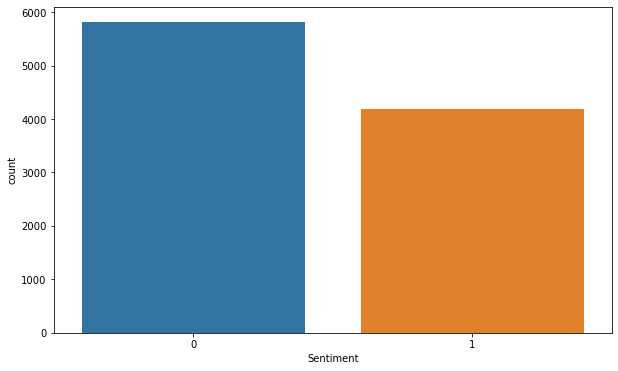

In [9]:
plt.figure(figsize = (10,6))
se.countplot(Y)

### Data Splitting
Since we are using a univariate dataset, we can directly split our data into training and testing subsets. The first subset is utilized to fit/train the model. The second subset is used for prediction. The main motive is to estimate the performance of the model on new data.

In [10]:
x_train,x_test,y_train,y_test=train_test_split(X,Y,test_size=0.2,random_state=123)

### Feature Transformation

**TfidfVectorizer** converts a collection of raw documents to a matrix of TF-IDF features.

It's equivalent to CountVectorizer followed by TfidfTransformer.

For more information on TfidfVectorizer [click here](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html)

In [11]:
vectorizer = TfidfVectorizer()
vectorizer.fit(x_train)

x_train = vectorizer.transform(x_train)
x_test  = vectorizer.transform(x_test)

#### Handling Target Imbalance
The challenge of working with imbalanced datasets is that most machine learning techniques will ignore, and in turn have poor performance on, the minority class, although typically it is performance on the minority class that is most important.

One approach to addressing imbalanced datasets is to oversample the minority class. The simplest approach involves duplicating examples in the minority class.We will perform overspampling using imblearn library.

In [12]:
x_train,y_train = RandomOverSampler(random_state=123).fit_resample(x_train, y_train)

## Model

Support vector machines (SVMs) are a set of supervised learning methods used for classification, regression and outliers detection.

A Support Vector Machine is a discriminative classifier formally defined by a separating hyperplane. In other terms, for a given known/labelled data points, the SVM outputs an appropriate hyperplane that classifies the inputted new cases based on the hyperplane. In 2-Dimensional space, this hyperplane is a line separating a plane into two segments where each class or group occupied on either side.

Here we have used SVC, the svc implementation is based on libsvm.


#### Model Tuning Parameters
 > - C -> Regularization parameter. The strength of the regularization is inversely proportional to C. Must be strictly positive.
 > - kernel -> Specifies the kernel type to be used in the algorithm. It must be one of ‘linear’, ‘poly’, ‘rbf’, ‘sigmoid’, ‘precomputed’ or a callable. If none is given, ‘rbf’ will be used. If a callable is given it is used to pre-compute the kernel matrix from data matrices; that matrix should be an array of shape (n_samples, n_samples).

> - gamma -> Gamma is a hyperparameter that we have to set before the training model. Gamma decides how much curvature we want in a decision boundary.

> - degree -> Degree of the polynomial kernel function (‘poly’). Ignored by all other kernels.Using degree 1 is similar to using a linear kernel. Also, increasing degree parameter leads to higher training times.

In [13]:
model=SVC(random_state=123)
model.fit(x_train,y_train)

SVC(random_state=123)

#### Model Accuracy
score() method return the mean accuracy on the given test data and labels.

In multi-label classification, this is the subset accuracy which is a harsh metric since you require for each sample that each label set be correctly predicted.

In [14]:
print("Accuracy score {:.2f} %\n".format(model.score(x_test,y_test)*100))

Accuracy score 76.21 %



#### Confusion Matrix
A confusion matrix is utilized to understand the performance of the classification model or algorithm in machine learning for a given test set where results are known.

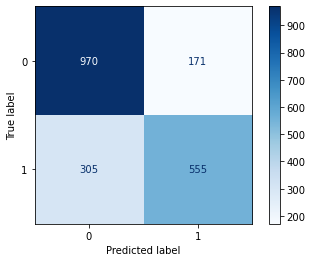

In [15]:
plot_confusion_matrix(model,x_test,y_test,cmap=plt.cm.Blues)

#### Classification Report
A Classification report is used to measure the quality of predictions from a classification algorithm. How many predictions are True, how many are False.
* where:
  - Precision:- Accuracy of positive predictions.
  -  Recall:- Fraction of positives that were correctly identified.
  -  f1-score:- percent of positive predictions were correct
  -  support:- Support is the number of actual occurrences of the class in the specified dataset.

In [16]:
print(classification_report(y_test,model.predict(x_test)))

              precision    recall  f1-score   support

           0       0.76      0.85      0.80      1141
           1       0.76      0.65      0.70       860

    accuracy                           0.76      2001
   macro avg       0.76      0.75      0.75      2001
weighted avg       0.76      0.76      0.76      2001



#### Creator: Viraj Jayant, Github: [Profile](https://github.com/Viraj-Jayant)